## 自动编码器
两种类型:
* 通过线性变换实现自动编码器模型
* 通过卷积变换实现自动编码器模型

### 1. 自动编码器(线性变换)

#### 1.1 模型结构

In [1]:
from turtle import forward
import torch
from torch import nn
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.encoder= nn.Sequential(
            nn.Linear(160*160*3,1024),
            nn.ReLU(),
            nn.Linear(1024,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),            
            nn.Linear(64,32),
            nn.ReLU(),
        )
        self.dencoder= nn.Sequential(
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),            
            nn.Linear(128,1024),
            nn.ReLU(),
            nn.Linear(1024,160*160*3),
        )
    def forward(self,x):
        output = self.encoder(x)
        output = self.dencoder(output)
        return output

In [2]:
model = AutoEncoder()
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=76800, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
  )
  (dencoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=76800, bias=True)
  )
)

### 1.2 数据集

In [3]:
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
import os
# imgs_name = os.listdir("../../../datas/kaggle/original-imgs/")
# for img_name in imgs_name:
#     path=os.path.join("../../../datas/kaggle/original-imgs",img_name)
#     img = Image.open(path)
#     # 高斯模糊处理
#     img=img.filter(ImageFilter.GaussianBlur(radius=10)) 
#     img.save(os.path.join("../../../datas/kaggle/mosaic-imgs",img_name))

In [4]:
from torch.utils.data import Dataset
from torchvision import transforms
class MyData(Dataset):
    def __init__(self,origin_dir,mosacio_dir):
        self.origin_dir = origin_dir
        self.mosacio_dir = mosacio_dir
        self.origin_path = [os.path.join(self.origin_dir,img) for img in os.listdir(origin_dir)]
        self.mosacio_path = [os.path.join(self.mosacio_dir,img) for img in os.listdir(mosacio_dir)]
        self.transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((160,160)),
            ]
        )

    def __len__(self):
        return self.origin_path.__len__()

    def __getitem__(self, index):
        origin_img = self.origin_path[index]
        mosacio_img = self.mosacio_path[index]
        origin_img = self.transforms(Image.open(origin_img))
        mosacio_img = self.transforms(Image.open(mosacio_img))
        origin_img = origin_img.view(-1)
        mosacio_img = mosacio_img.view(-1)
        return origin_img,mosacio_img

In [5]:
mydata = MyData("../../../datas/kaggle/original-imgs","../../../datas/kaggle/mosaic-imgs")

### 1.3 数据加载

In [6]:
from torch.utils.data import DataLoader
data_load = DataLoader(
    mydata,
    batch_size = 128,
    shuffle = True,
    num_workers = 0,
    pin_memory = True
)

### 1.4 超参数

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fn = nn.MSELoss()
loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

epoch = 5


### 1.5 训练

In [8]:
for i in range(epoch):
    print("-------------第{}轮训练开始------------".format(i+1))
    # 训练步骤开始
    model.train()
    for data in data_load:
        imgs,targets = data
        imgs = imgs.to(device)
        targets = targets.to(device)
        outputs = model(imgs)
        loss = loss_fn(outputs,targets)
        
        # 优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("训练轮数：{},loss:{}".format(i+1,loss.item()))
    # 保存模型
    if i == epoch-1:
        torch.save(model.state_dict(),"./models/autoencoderl_model.pth")
        print("模型已保存")


-------------第1轮训练开始------------
训练轮数：1,loss:0.05024689435958862
-------------第2轮训练开始------------
训练轮数：2,loss:0.049654413014650345
-------------第3轮训练开始------------
训练轮数：3,loss:0.04779035598039627
-------------第4轮训练开始------------
训练轮数：4,loss:0.03267597407102585
-------------第5轮训练开始------------
训练轮数：5,loss:0.03607673570513725
模型已保存


### 1.6 预测

In [9]:
# 模型加载
model = AutoEncoder()
model_status = torch.load("./models/autoencoderl_model.pth")
model.load_state_dict(model_status)

<All keys matched successfully>

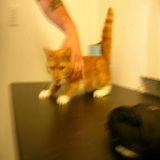

In [10]:
from PIL import Image
from torchvision import transforms
cat = Image.open("../../../datas/kaggle/cat/cat.0.jpg")
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((160,160)),
    ]
)
toPil = transforms.ToPILImage()
t_cat = transform(cat)
toPil(t_cat)

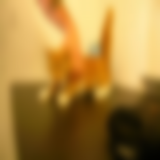

In [11]:
m_cat = cat.filter(ImageFilter.GaussianBlur(radius=10))
t_m_cat = transform(m_cat)
toPil(t_m_cat)

In [12]:
t_m_cat.shape

torch.Size([3, 160, 160])

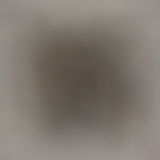

In [17]:
img = model(t_m_cat.view(-1))
img = img.view(3,160,160)
toPil(img)

### 2. 自动编码器(卷积变换)

### 2.1 模型结构

In [1]:
from turtle import forward
import torch
from torch import nn
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.encoder= nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.dencoder= nn.Sequential(
            # 上采样
            nn.Upsample(scale_factor=2,mode="nearest"),
            nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2,mode="nearest"),
            nn.Conv2d(64,3,kernel_size=3,stride=1,padding=1),
        )
    def forward(self,x):
        output = self.encoder(x)
        output = output.view(-1,128,40,40)
        output = self.dencoder(output)
        output = output.view(-1,3,160,160)
        return output

In [2]:
model = AutoEncoder()
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dencoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
    (4): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

### 2.2 数据集

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image,ImageFilter
class MyData(Dataset):
    def __init__(self,origin_dir,mosacio_dir):
        self.origin_dir = origin_dir
        self.mosacio_dir = mosacio_dir
        self.origin_path = [os.path.join(self.origin_dir,img) for img in os.listdir(origin_dir)]
        self.mosacio_path = [os.path.join(self.mosacio_dir,img) for img in os.listdir(mosacio_dir)]
        self.transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((160,160)),
            ]
        )

    def __len__(self):
        return self.origin_path.__len__()

    def __getitem__(self, index):
        origin_img = self.origin_path[index]
        mosacio_img = self.mosacio_path[index]
        origin_img = self.transforms(Image.open(origin_img))
        mosacio_img = self.transforms(Image.open(mosacio_img))
        return origin_img,mosacio_img

In [4]:
mydata = MyData("../../../datas/kaggle/original-imgs","../../../datas/kaggle/mosaic-imgs")

In [5]:
model(mydata[0][0]).shape

torch.Size([1, 3, 160, 160])

### 2.3 数据加载

In [6]:
from torch.utils.data import DataLoader
data_load = DataLoader(
    mydata,
    batch_size = 32,
    shuffle = True,
    num_workers = 0,
    pin_memory = True
)

### 2.4 超参数

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fn = nn.MSELoss()
loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

epoch = 5


### 2.5 训练

In [8]:
for i in range(epoch):
    print("-------------第{}轮训练开始------------".format(i+1))
    # 训练步骤开始
    model.train()
    for data in data_load:
        imgs,targets = data
        imgs = imgs.to(device)
        targets = targets.to(device)
        outputs = model(imgs)
        loss = loss_fn(outputs,targets)
        
        # 优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("训练轮数：{},loss:{}".format(i+1,loss.item()))
    # 保存模型
    if i == epoch-1:
        torch.save(model.state_dict(),"./models/autoencoderc_model.pth")
        print("模型已保存")


-------------第1轮训练开始------------
训练轮数：1,loss:0.005610646679997444
-------------第2轮训练开始------------
训练轮数：2,loss:0.007617686875164509
-------------第3轮训练开始------------
训练轮数：3,loss:0.01452704332768917
-------------第4轮训练开始------------
训练轮数：4,loss:0.005764573812484741
-------------第5轮训练开始------------
训练轮数：5,loss:0.006467860657721758
模型已保存


### 2.6 预测

In [9]:
# 模型加载
model = AutoEncoder()
model_status = torch.load("./models/autoencoderc_model.pth")
model.load_state_dict(model_status)

<All keys matched successfully>

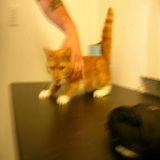

In [10]:
from PIL import Image
from torchvision import transforms
cat = Image.open("../../../datas/kaggle/cat/cat.0.jpg")
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((160,160)),
    ]
)
toPil = transforms.ToPILImage()
t_cat = transform(cat)
toPil(t_cat)

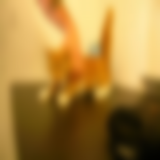

In [11]:
m_cat = cat.filter(ImageFilter.GaussianBlur(radius=10))
t_m_cat = transform(m_cat)
toPil(t_m_cat)

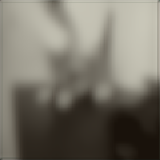

In [17]:
img = model(t_m_cat)
# img = img.view(3,160,160)
toPil(img[0])